In [3]:
import json
from urllib import parse
import pandas as pd
import sqlite3
import numpy as np
from matplotlib import colors, cm, pyplot as plt
import urllib.request
from PIL import Image

In [4]:
PIXELS_X = 910
PIXELS_Y = 910  # equal to the number of scan lines
MZ_MIN = 100.0
MZ_MAX = 1700.0
SCAN_MAX = PIXELS_Y
SCAN_MIN = 1
MZ_PER_TILE = 18.0
TILES_PER_FRAME = int((MZ_MAX - MZ_MIN) / MZ_PER_TILE) + 1
MIN_TILE_IDX = 0
MAX_TILE_IDX = TILES_PER_FRAME-1

In [82]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [97]:
# how long in RT do we look either side of the selected frame
RT_RANGE = 2.0

In [98]:
MZ_PER_PIXEL_X = MZ_PER_TILE / PIXELS_X
MZ_PER_PIXEL_X

0.01978021978021978

In [99]:
# get the m/z for a x coordinate on a specified tile
def mz_from_tile_pixel_x(tile_id, pixel_x):
    mz_lower = MZ_MIN + (tile_id * MZ_PER_TILE)
    mz = mz_lower + (pixel_x * MZ_PER_PIXEL_X)
    return mz

In [100]:
annotation_file_name = '/Users/darylwilding-mcbride/Downloads/via_export_json (14).json'

In [101]:
# load an annotations file
with open(annotation_file_name) as file:
    annotations = json.load(file)


In [102]:
tile_key = list(annotations.keys())[32]

In [103]:
tile_key

'http://spectra-server-lb-1653892276.ap-southeast-2.elb.amazonaws.com/tile/run/190719_Hela_Ecoli_1to1_02/tile/32/frame/2050-1'

In [104]:
tile_d = annotations[tile_key]
tile_url = tile_d['filename']

splits = parse.urlsplit(tile_url).path.split('/')
run_name = splits[3]
tile_id = int(splits[5])
frame_id = int(splits[7])

tile_regions = tile_d['regions']

In [105]:
run_name, tile_id, frame_id

('190719_Hela_Ecoli_1to1_02', 32, 2050)

In [106]:
len(tile_regions)

8

In [107]:
feature_idx = 6
shape_attributes = tile_regions[feature_idx]['shape_attributes']
region_attributes = tile_regions[feature_idx]['region_attributes']

In [108]:
mz_lower = mz_from_tile_pixel_x(tile_id=tile_id, pixel_x=shape_attributes['x'])
mz_upper = mz_from_tile_pixel_x(tile_id=tile_id, pixel_x=shape_attributes['x'] + shape_attributes['width'])

In [109]:
mz_lower, mz_upper

(679.6395604395605, 682.5076923076923)

In [110]:
scan_lower = shape_attributes['y']
scan_upper = shape_attributes['y'] + shape_attributes['height']

In [111]:
scan_lower, scan_upper

(627, 687)

In [112]:
db_file_name = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/converted-databases/exp-dwm-test-run-{}-converted.sqlite'.format(run_name)

In [113]:
# get the RT for this frame
db_conn = sqlite3.connect(db_file_name)
df = pd.read_sql_query('select Time from frame_properties where Id == {}'.format(frame_id), db_conn)
db_conn.close()

In [114]:
retention_time = df.iloc[0].Time
retention_time

216.98727065751814

In [115]:
rt_lower = retention_time - RT_RANGE
rt_upper = retention_time + RT_RANGE

In [124]:
# get the raw data for this feature
db_conn = sqlite3.connect(db_file_name)
raw_df = pd.read_sql_query('select mz,scan,intensity,frame_id,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and frame_type == {} and retention_time_secs >= {} and retention_time_secs <= {}'.format(mz_lower, mz_upper, scan_lower, scan_upper, FRAME_TYPE_MS1, rt_lower, rt_upper), db_conn)
db_conn.close()

In [125]:
colour_map = plt.get_cmap('rainbow')
norm = colors.LogNorm(vmin=1, vmax=1000, clip=True)  # aiming to get good colour variation in the lower range, and clipping everything else

In [131]:
# calculate the colour to represent the intensity
colours_l = []
for i in raw_df.intensity.unique():
    colours_l.append((i, colour_map(norm(i), bytes=False)[:3]))
colours_df = pd.DataFrame(colours_l, columns=['intensity','colour'])
raw_colour_df = pd.merge(raw_df, colours_df, how='left', left_on=['intensity'], right_on=['intensity'])

In [132]:
frames_l = []
for group_name,group_df in raw_colour_df.groupby(['frame_id'], as_index=False):
    frames_l.append(group_df)

In [133]:
len(frames_l)

7

In [138]:
columns = 2
rows = int(len(frames_l) / columns)

In [139]:
rows

3

In [140]:
if len(frames_l) % columns != 0:
    rows += 1

In [141]:
rows

4

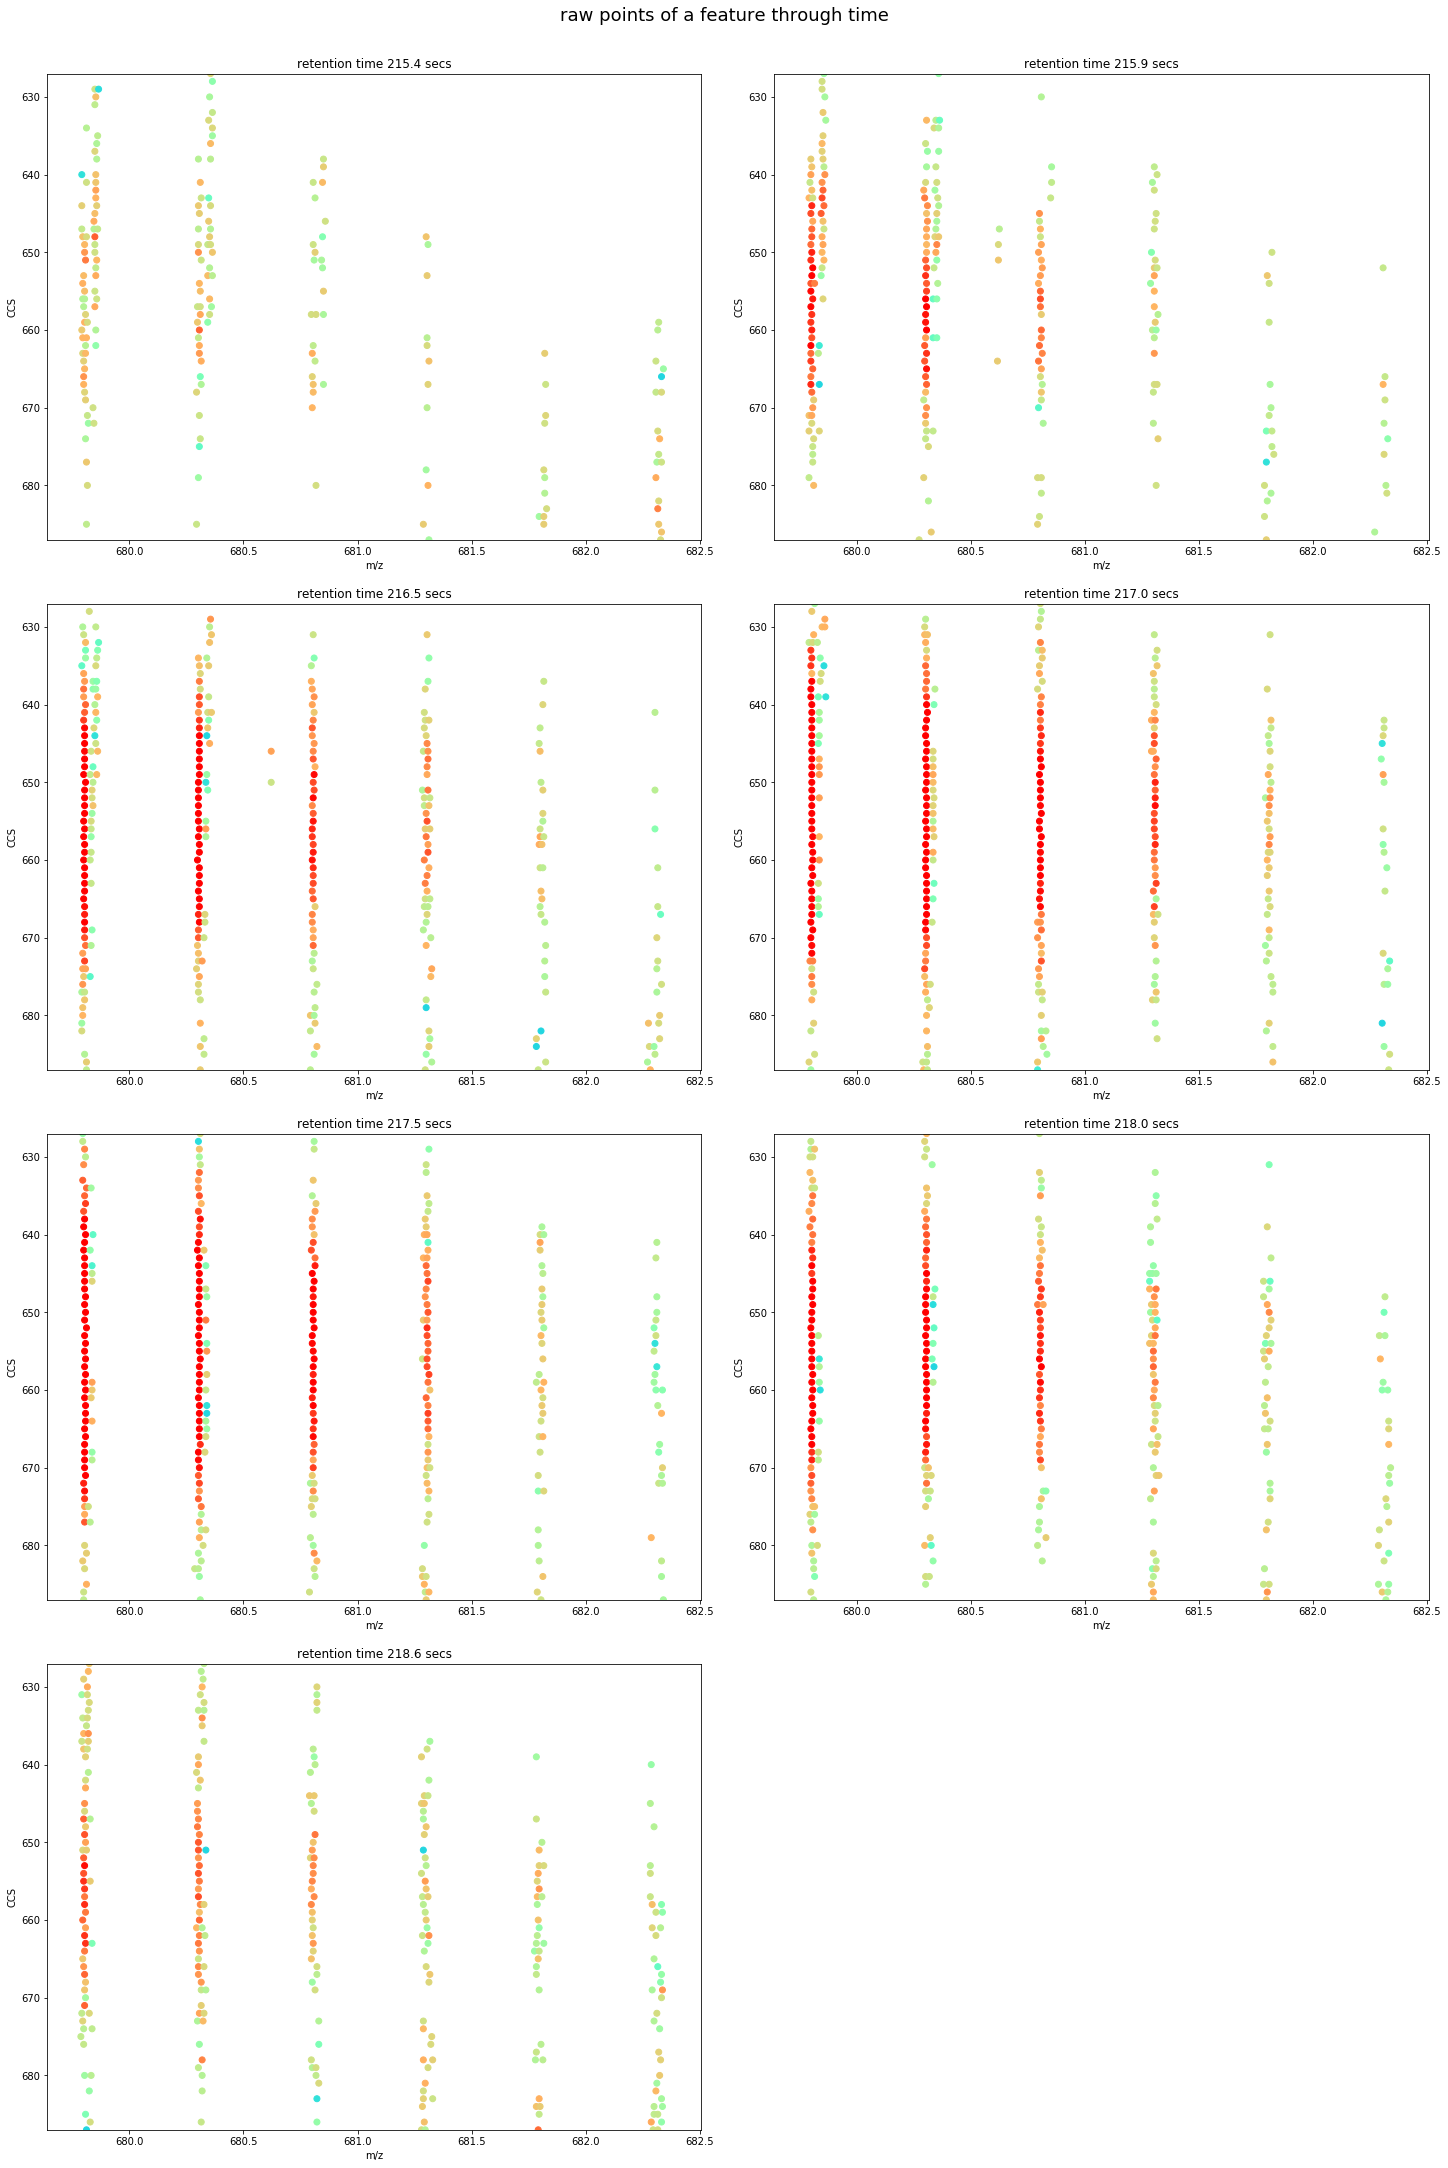

In [144]:
f, axarr = plt.subplots(nrows=rows, ncols=columns, constrained_layout=True)
f.set_figheight(30)
f.set_figwidth(20)
f.suptitle('raw points of a feature through time\n', fontsize=18)

# turn off the axes if the last row is incomplete
if len(frames_l) % columns != 0:
    axarr[-1, -1].axis('off')

plt.margins(0.06)

for row_idx,frame_df in enumerate(frames_l):
    r = int(row_idx / 2)
    c = row_idx % 2
    ax = axarr[r,c]  # row, column

    retention_time = frame_df.iloc[0].retention_time_secs
    ax.set_title('retention time {} secs'.format(round(retention_time,1)))

    ax.scatter(frame_df.mz, frame_df.scan, c=frame_df.colour)

    # set up axes
    ax.set_xlim((mz_lower,mz_upper))
    ax.set_ylim((scan_upper,scan_lower))
    ax.set_xlabel('m/z')
    ax.set_ylabel('CCS')

plt.show()